<a href="https://colab.research.google.com/github/srilamaiti/SM_MIDS_W207_HW/blob/main/facial_emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob
import random
from imutils import rotate as rotate
from itertools import product
import gc
from sklearn.utils import shuffle
import cv2 as cv
import skimage.io as skio

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.python.ops.numpy_ops import np_config
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
np_config.enable_numpy_behavior()
from PIL import Image
import cv2

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
labels = ['happy', 'sad', 'fear', 'angry', 'neutral', 'surprise', 'disgust']
label_dict = {'happy' : 1, 'sad' : 2, 'fear' : 3, 'angry' : 4, 'neutral' : 5, 'surprise' : 6, 'disgust' : 7}

In [3]:
current_working_dir = '/content/gdrive/MyDrive' #os.getcwd()
image_file_extension = '.jpg'
train_path = 'fdtct_train'
test_path = 'fdtct_test'
validation_path = 'fdtct_validation'

happy_path = 'happy'
sad_path = 'sad'
disgust_path = 'disgust'
angry_path = 'angry'
surprise_path = 'surprise'
fear_path = 'fear'
neutral_path = 'neutral'

In [4]:
def get_file_names(dir, image_file_extension = 'jpg'):
    """
    This function lists all the files in the directory.
    """
    return glob.glob(dir + '/*.'+ image_file_extension)

In [5]:
def read_image_file_in_np_array(image_file_name_list):
    """
    This function reads each image file in a Numpy array and returns it.
    """
    return np.asarray([cv2.imread(image_file) for image_file in image_file_name_list])

In [16]:
def convert_np_array_to_tensor(np_image_array):
    """
    This function converts the numpy array representation of each image in tensor.
    """
    return tf.convert_to_tensor(np_image_array, dtype = tf.float32)

In [32]:
def create_label(array_length, val):
    """
    This function creates array of the given value
    """
    label_np = np.empty(array_length); label_np.fill(val)
    return label_np

In [43]:
def convert_to_grayscale(tf_image_list):
    """
    This function converts color image to grayscale.
    """
    return tf.image.rgb_to_grayscale(tf_image_list) / 255.0

In [6]:
train_happy_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, happy_path))
train_sad_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, sad_path))
train_angry_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, angry_path))
train_surprise_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, surprise_path))
train_fear_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, fear_path))
train_neutral_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, neutral_path))
train_disgust_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, disgust_path))

In [7]:
print(f"Number of train happy files: {len(train_happy_file_list)}")
print(f"Number of train sad files: {len(train_sad_file_list)}")
print(f"Number of train angry files: {len(train_angry_file_list)}")
print(f"Number of train neutral files: {len(train_neutral_file_list)}")
print(f"Number of train disgust files: {len(train_disgust_file_list)}")
print(f"Number of train fear files: {len(train_fear_file_list)}")
print(f"Number of train surprise files: {len(train_surprise_file_list)}")

Number of train happy files: 350
Number of train sad files: 350
Number of train angry files: 350
Number of train neutral files: 350
Number of train disgust files: 350
Number of train fear files: 350
Number of train surprise files: 350


In [8]:
test_happy_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, happy_path))
test_sad_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, sad_path))
test_angry_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, angry_path))
test_surprise_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, surprise_path))
test_fear_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, fear_path))
test_neutral_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, neutral_path))
test_disgust_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, disgust_path))

In [9]:
print(f"Number of test happy files: {len(test_happy_file_list)}")
print(f"Number of test sad files: {len(test_sad_file_list)}")
print(f"Number of test angry files: {len(test_angry_file_list)}")
print(f"Number of test neutral files: {len(test_neutral_file_list)}")
print(f"Number of test disgust files: {len(test_disgust_file_list)}")
print(f"Number of test fear files: {len(test_fear_file_list)}")
print(f"Number of test surprise files: {len(test_surprise_file_list)}")

Number of test happy files: 112
Number of test sad files: 112
Number of test angry files: 112
Number of test neutral files: 112
Number of test disgust files: 111
Number of test fear files: 112
Number of test surprise files: 112


In [10]:
validation_happy_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, happy_path))
validation_sad_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, sad_path))
validation_angry_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, angry_path))
validation_surprise_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, surprise_path))
validation_fear_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, fear_path))
validation_neutral_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, neutral_path))
validation_disgust_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, disgust_path))

In [11]:
print(f"Number of validation happy files: {len(validation_happy_file_list)}")
print(f"Number of validation sad files: {len(validation_sad_file_list)}")
print(f"Number of validation angry files: {len(validation_angry_file_list)}")
print(f"Number of validation neutral files: {len(validation_neutral_file_list)}")
print(f"Number of validation disgust files: {len(validation_disgust_file_list)}")
print(f"Number of validation fear files: {len(validation_fear_file_list)}")
print(f"Number of validation surprise files: {len(validation_surprise_file_list)}")

Number of validation happy files: 87
Number of validation sad files: 87
Number of validation angry files: 87
Number of validation neutral files: 87
Number of validation disgust files: 87
Number of validation fear files: 87
Number of validation surprise files: 87


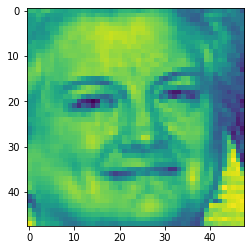

In [12]:
import matplotlib.pyplot as plt
image = plt.imread(os.path.join(current_working_dir, validation_path, happy_path) + '/100.jpg')
plt.imshow(image)

In [13]:
train_happy_np = read_image_file_in_np_array(image_file_name_list = train_happy_file_list)
train_sad_np = read_image_file_in_np_array(image_file_name_list = train_sad_file_list)
train_angry_np = read_image_file_in_np_array(image_file_name_list = train_angry_file_list)
train_fear_np = read_image_file_in_np_array(image_file_name_list = train_fear_file_list)
train_surprise_np = read_image_file_in_np_array(image_file_name_list = train_surprise_file_list)
train_neutral_np = read_image_file_in_np_array(image_file_name_list = train_neutral_file_list)
train_disgust_np = read_image_file_in_np_array(image_file_name_list = train_disgust_file_list)

In [14]:
validation_happy_np = read_image_file_in_np_array(image_file_name_list = validation_happy_file_list)
validation_sad_np = read_image_file_in_np_array(image_file_name_list = validation_sad_file_list)
validation_angry_np = read_image_file_in_np_array(image_file_name_list = validation_angry_file_list)
validation_fear_np = read_image_file_in_np_array(image_file_name_list = validation_fear_file_list)
validation_surprise_np = read_image_file_in_np_array(image_file_name_list = validation_surprise_file_list)
validation_neutral_np = read_image_file_in_np_array(image_file_name_list = validation_neutral_file_list)
validation_disgust_np = read_image_file_in_np_array(image_file_name_list = validation_disgust_file_list)

In [15]:
test_happy_np = read_image_file_in_np_array(image_file_name_list = test_happy_file_list)
test_sad_np = read_image_file_in_np_array(image_file_name_list = test_sad_file_list)
test_angry_np = read_image_file_in_np_array(image_file_name_list = test_angry_file_list)
test_fear_np = read_image_file_in_np_array(image_file_name_list = test_fear_file_list)
test_surprise_np = read_image_file_in_np_array(image_file_name_list = test_surprise_file_list)
test_neutral_np = read_image_file_in_np_array(image_file_name_list = test_neutral_file_list)
test_disgust_np = read_image_file_in_np_array(image_file_name_list = test_disgust_file_list)

In [17]:
print(f"Shape of train_happy_np : {train_happy_np.shape}")
print(f"Shape of train_sad_np : {train_sad_np.shape}")
print(f"Shape of train_angry_np : {train_angry_np.shape}")
print(f"Shape of train_fear_np : {train_fear_np.shape}")
print(f"Shape of train_surprise_np : {train_surprise_np.shape}")
print(f"Shape of train_neutral_np : {train_neutral_np.shape}")
print(f"Shape of train_disgust_np : {train_disgust_np.shape}")

Shape of train_happy_np : (350, 48, 48, 3)
Shape of train_sad_np : (350, 48, 48, 3)
Shape of train_angry_np : (350, 48, 48, 3)
Shape of train_fear_np : (350, 48, 48, 3)
Shape of train_surprise_np : (350, 48, 48, 3)
Shape of train_neutral_np : (350, 48, 48, 3)
Shape of train_disgust_np : (350, 48, 48, 3)


In [18]:
print(f"Shape of test_happy_np : {test_happy_np.shape}")
print(f"Shape of test_sad_np : {test_sad_np.shape}")
print(f"Shape of test_angry_np : {test_angry_np.shape}")
print(f"Shape of test_fear_np : {test_fear_np.shape}")
print(f"Shape of test_surprise_np : {test_surprise_np.shape}")
print(f"Shape of test_neutral_np : {test_neutral_np.shape}")
print(f"Shape of test_disgust_np : {test_disgust_np.shape}")

Shape of test_happy_np : (112, 48, 48, 3)
Shape of test_sad_np : (112, 48, 48, 3)
Shape of test_angry_np : (112, 48, 48, 3)
Shape of test_fear_np : (112, 48, 48, 3)
Shape of test_surprise_np : (112, 48, 48, 3)
Shape of test_neutral_np : (112, 48, 48, 3)
Shape of test_disgust_np : (111, 48, 48, 3)


In [19]:
print(f"Shape of validation_happy_np : {validation_happy_np.shape}")
print(f"Shape of validation_sad_np : {validation_sad_np.shape}")
print(f"Shape of validation_angry_np : {validation_angry_np.shape}")
print(f"Shape of validation_fear_np : {validation_fear_np.shape}")
print(f"Shape of validation_surprise_np : {validation_surprise_np.shape}")
print(f"Shape of validation_neutral_np : {validation_neutral_np.shape}")
print(f"Shape of validation_disgust_np : {validation_disgust_np.shape}")

Shape of validation_happy_np : (87, 48, 48, 3)
Shape of validation_sad_np : (87, 48, 48, 3)
Shape of validation_angry_np : (87, 48, 48, 3)
Shape of validation_fear_np : (87, 48, 48, 3)
Shape of validation_surprise_np : (87, 48, 48, 3)
Shape of validation_neutral_np : (87, 48, 48, 3)
Shape of validation_disgust_np : (87, 48, 48, 3)


In [20]:
train_happy_tf = convert_np_array_to_tensor(train_happy_np)
train_sad_tf = convert_np_array_to_tensor(train_sad_np)
train_angry_tf = convert_np_array_to_tensor(train_angry_np)
train_fear_tf = convert_np_array_to_tensor(train_fear_np)
train_surprise_tf = convert_np_array_to_tensor(train_surprise_np)
train_neutral_tf = convert_np_array_to_tensor(train_neutral_np)
train_disgust_tf = convert_np_array_to_tensor(train_disgust_np)

In [21]:
validation_happy_tf = convert_np_array_to_tensor(validation_happy_np)
validation_sad_tf = convert_np_array_to_tensor(validation_sad_np)
validation_angry_tf = convert_np_array_to_tensor(validation_angry_np)
validation_fear_tf = convert_np_array_to_tensor(validation_fear_np)
validation_surprise_tf = convert_np_array_to_tensor(validation_surprise_np)
validation_neutral_tf = convert_np_array_to_tensor(validation_neutral_np)
validation_disgust_tf = convert_np_array_to_tensor(validation_disgust_np)

In [22]:
test_happy_tf = convert_np_array_to_tensor(test_happy_np)
test_sad_tf = convert_np_array_to_tensor(test_sad_np)
test_angry_tf = convert_np_array_to_tensor(test_angry_np)
test_fear_tf = convert_np_array_to_tensor(test_fear_np)
test_surprise_tf = convert_np_array_to_tensor(test_surprise_np)
test_neutral_tf = convert_np_array_to_tensor(test_neutral_np)
test_disgust_tf = convert_np_array_to_tensor(test_disgust_np)

In [23]:
print(f"Shape of train_happy_tf : {train_happy_tf.shape}")
print(f"Shape of train_sad_tf : {train_sad_tf.shape}")
print(f"Shape of train_angry_tf : {train_angry_tf.shape}")
print(f"Shape of train_fear_tf : {train_fear_tf.shape}")
print(f"Shape of train_surprise_tf : {train_surprise_tf.shape}")
print(f"Shape of train_neutral_tf : {train_neutral_tf.shape}")
print(f"Shape of train_disgust_tf : {train_disgust_tf.shape}")

Shape of train_happy_tf : (350, 48, 48, 3)
Shape of train_sad_tf : (350, 48, 48, 3)
Shape of train_angry_tf : (350, 48, 48, 3)
Shape of train_fear_tf : (350, 48, 48, 3)
Shape of train_surprise_tf : (350, 48, 48, 3)
Shape of train_neutral_tf : (350, 48, 48, 3)
Shape of train_disgust_tf : (350, 48, 48, 3)


In [24]:
print(f"Shape of test_happy_tf : {test_happy_tf.shape}")
print(f"Shape of test_sad_tf : {test_sad_tf.shape}")
print(f"Shape of test_angry_tf : {test_angry_tf.shape}")
print(f"Shape of test_fear_tf : {test_fear_tf.shape}")
print(f"Shape of test_surprise_tf : {test_surprise_tf.shape}")
print(f"Shape of test_neutral_tf : {test_neutral_tf.shape}")
print(f"Shape of test_disgust_tf : {test_disgust_tf.shape}")

Shape of test_happy_tf : (112, 48, 48, 3)
Shape of test_sad_tf : (112, 48, 48, 3)
Shape of test_angry_tf : (112, 48, 48, 3)
Shape of test_fear_tf : (112, 48, 48, 3)
Shape of test_surprise_tf : (112, 48, 48, 3)
Shape of test_neutral_tf : (112, 48, 48, 3)
Shape of test_disgust_tf : (111, 48, 48, 3)


In [25]:
print(f"Shape of validation_happy_tf : {validation_happy_tf.shape}")
print(f"Shape of validation_sad_tf : {validation_sad_tf.shape}")
print(f"Shape of validation_angry_tf : {validation_angry_tf.shape}")
print(f"Shape of validation_fear_tf : {validation_fear_tf.shape}")
print(f"Shape of validation_surprise_tf : {validation_surprise_tf.shape}")
print(f"Shape of validation_neutral_tf : {validation_neutral_tf.shape}")
print(f"Shape of validation_disgust_tf : {validation_disgust_tf.shape}")

Shape of validation_happy_tf : (87, 48, 48, 3)
Shape of validation_sad_tf : (87, 48, 48, 3)
Shape of validation_angry_tf : (87, 48, 48, 3)
Shape of validation_fear_tf : (87, 48, 48, 3)
Shape of validation_surprise_tf : (87, 48, 48, 3)
Shape of validation_neutral_tf : (87, 48, 48, 3)
Shape of validation_disgust_tf : (87, 48, 48, 3)


In [37]:
label_train_happy_np = create_label(array_length = len(train_happy_np), val = label_dict['happy'])
label_train_sad_np = create_label(array_length = len(train_sad_np), val = label_dict['sad'])
label_train_angry_np = create_label(array_length = len(train_angry_np), val = label_dict['angry'])
label_train_fear_np = create_label(array_length = len(train_fear_np), val = label_dict['fear'])
label_train_surprise_np = create_label(array_length = len(train_surprise_np), val = label_dict['surprise'])
label_train_disgust_np = create_label(array_length = len(train_disgust_np), val = label_dict['disgust'])
label_train_neutral_np = create_label(array_length = len(train_neutral_np), val = label_dict['neutral'])

In [38]:
label_test_happy_np = create_label(array_length = len(test_happy_np), val = label_dict['happy'])
label_test_sad_np = create_label(array_length = len(test_sad_np), val = label_dict['sad'])
label_test_angry_np = create_label(array_length = len(test_angry_np), val = label_dict['angry'])
label_test_fear_np = create_label(array_length = len(test_fear_np), val = label_dict['fear'])
label_test_surprise_np = create_label(array_length = len(test_surprise_np), val = label_dict['surprise'])
label_test_disgust_np = create_label(array_length = len(test_disgust_np), val = label_dict['disgust'])
label_test_neutral_np = create_label(array_length = len(test_neutral_np), val = label_dict['neutral'])

In [39]:
label_validation_happy_np = create_label(array_length = len(validation_happy_np), val = label_dict['happy'])
label_validation_sad_np = create_label(array_length = len(validation_sad_np), val = label_dict['sad'])
label_validation_angry_np = create_label(array_length = len(validation_angry_np), val = label_dict['angry'])
label_validation_fear_np = create_label(array_length = len(validation_fear_np), val = label_dict['fear'])
label_validation_surprise_np = create_label(array_length = len(validation_surprise_np), val = label_dict['surprise'])
label_validation_disgust_np = create_label(array_length = len(validation_disgust_np), val = label_dict['disgust'])
label_validation_neutral_np = create_label(array_length = len(validation_neutral_np), val = label_dict['neutral'])

In [40]:
print(f"Shape of label_train_happy_np : {label_train_happy_np.shape}")
print(f"Shape of label_train_sad_np : {label_train_sad_np.shape}")
print(f"Shape of label_train_angry_np : {label_train_angry_np.shape}")
print(f"Shape of label_train_fear_np : {label_train_fear_np.shape}")
print(f"Shape of label_train_surprise_np : {label_train_surprise_np.shape}")
print(f"Shape of label_train_neutral_np : {label_train_neutral_np.shape}")
print(f"Shape of label_train_disgust_np : {label_train_disgust_np.shape}")

Shape of label_train_happy_np : (350,)
Shape of label_train_sad_np : (350,)
Shape of label_train_angry_np : (350,)
Shape of label_train_fear_np : (350,)
Shape of label_train_surprise_np : (350,)
Shape of label_train_neutral_np : (350,)
Shape of label_train_disgust_np : (350,)


In [41]:
print(f"Shape of label_test_happy_np : {label_test_happy_np.shape}")
print(f"Shape of label_test_sad_np : {label_test_sad_np.shape}")
print(f"Shape of label_test_angry_np : {label_test_angry_np.shape}")
print(f"Shape of label_test_fear_np : {label_test_fear_np.shape}")
print(f"Shape of label_test_surprise_np : {label_test_surprise_np.shape}")
print(f"Shape of label_test_neutral_np : {label_test_neutral_np.shape}")
print(f"Shape of label_test_disgust_np : {label_test_disgust_np.shape}")

Shape of label_test_happy_np : (112,)
Shape of label_test_sad_np : (112,)
Shape of label_test_angry_np : (112,)
Shape of label_test_fear_np : (112,)
Shape of label_test_surprise_np : (112,)
Shape of label_test_neutral_np : (112,)
Shape of label_test_disgust_np : (111,)


In [42]:
print(f"Shape of label_validation_happy_np : {label_validation_happy_np.shape}")
print(f"Shape of label_validation_sad_np : {label_validation_sad_np.shape}")
print(f"Shape of label_validation_angry_np : {label_validation_angry_np.shape}")
print(f"Shape of label_validation_fear_np : {label_validation_fear_np.shape}")
print(f"Shape of label_validation_surprise_np : {label_validation_surprise_np.shape}")
print(f"Shape of label_validation_neutral_np : {label_validation_neutral_np.shape}")
print(f"Shape of label_validation_disgust_np : {label_validation_disgust_np.shape}")

Shape of label_validation_happy_np : (87,)
Shape of label_validation_sad_np : (87,)
Shape of label_validation_angry_np : (87,)
Shape of label_validation_fear_np : (87,)
Shape of label_validation_surprise_np : (87,)
Shape of label_validation_neutral_np : (87,)
Shape of label_validation_disgust_np : (87,)


In [44]:
train_happy_tf = convert_to_grayscale(train_happy_tf)
train_sad_tf = convert_to_grayscale(train_sad_tf)
train_angry_tf = convert_to_grayscale(train_angry_tf)
train_fear_tf = convert_to_grayscale(train_fear_tf)
train_surprise_tf = convert_to_grayscale(train_surprise_tf)
train_neutral_tf = convert_to_grayscale(train_neutral_tf)
train_disgust_tf = convert_to_grayscale(train_disgust_tf)

In [45]:
test_happy_tf = convert_to_grayscale(test_happy_tf)
test_sad_tf = convert_to_grayscale(test_sad_tf)
test_angry_tf = convert_to_grayscale(test_angry_tf)
test_fear_tf = convert_to_grayscale(test_fear_tf)
test_surprise_tf = convert_to_grayscale(test_surprise_tf)
test_neutral_tf = convert_to_grayscale(test_neutral_tf)
test_disgust_tf = convert_to_grayscale(test_disgust_tf)

In [46]:
validation_happy_tf = convert_to_grayscale(validation_happy_tf)
validation_sad_tf = convert_to_grayscale(validation_sad_tf)
validation_angry_tf = convert_to_grayscale(validation_angry_tf)
validation_fear_tf = convert_to_grayscale(validation_fear_tf)
validation_surprise_tf = convert_to_grayscale(validation_surprise_tf)
validation_neutral_tf = convert_to_grayscale(validation_neutral_tf)
validation_disgust_tf = convert_to_grayscale(validation_disgust_tf)

In [49]:
total_train = len(train_happy_np) + len(train_sad_np) + len(train_angry_np) + len(train_fear_np) + len(train_disgust_np) + len(train_surprise_np) + len(train_neutral_np)
total_validation = len(validation_happy_np) + len(validation_sad_np) + len(validation_angry_np) + len(validation_fear_np) + len(validation_disgust_np) + len(validation_surprise_np) + len(validation_neutral_np)
total_test = len(test_happy_np) + len(test_sad_np) + len(test_angry_np) + len(test_fear_np) + len(test_disgust_np) + len(test_surprise_np) + len(test_neutral_np)

In [50]:
print(f"Total train : {total_train}")
print(f"Total test : {total_test}")
print(f"Total validation : {total_validation}")

Total train : 2450
Total test : 783
Total validation : 609


In [51]:
batch_size = 100
image_shape = 48

In [52]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=os.path.join(current_working_dir, train_path),
                                               shuffle=True,
                                               target_size=(image_shape,image_shape))

Found 2450 images belonging to 7 classes.


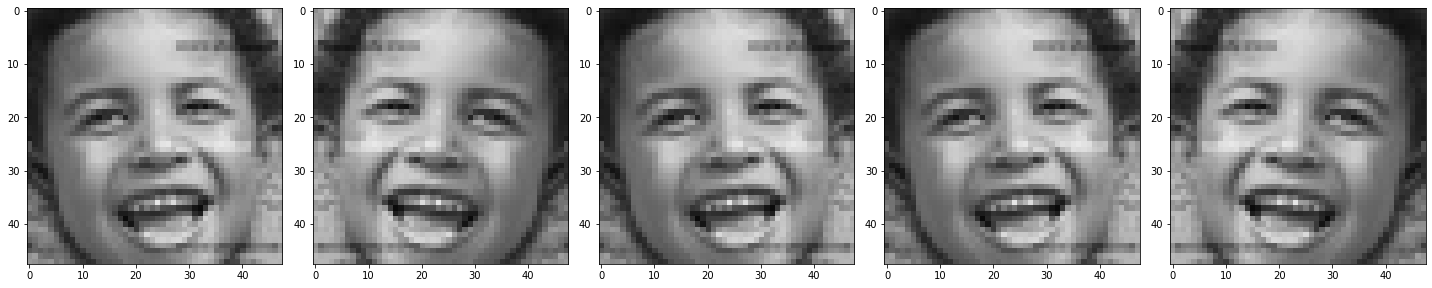

In [53]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [54]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.15,
      height_shift_range=0.15,
      #shear_range=0.2,
      zoom_range=0.5,
      horizontal_flip=False,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=os.path.join(current_working_dir, train_path),
                                                     shuffle=True,
                                                     target_size=(image_shape,image_shape),
                                                     class_mode='sparse')

Found 2450 images belonging to 7 classes.


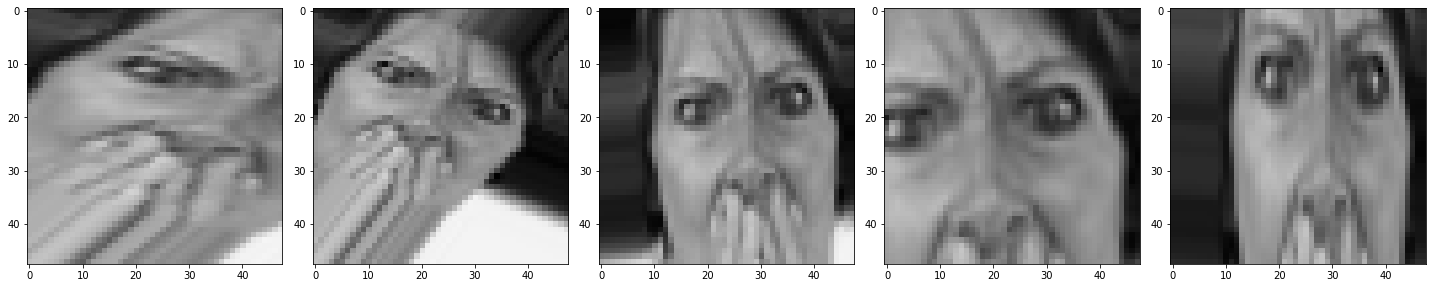

In [55]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [56]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=os.path.join(current_working_dir, validation_path),
                                                 target_size=(image_shape, image_shape),
                                                 class_mode='sparse')

Found 609 images belonging to 7 classes.


In [64]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(image_shape, image_shape, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7)
])

In [65]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 64)        

In [68]:
epochs=80
history1 = model1.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_validation / float(batch_size)))
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/80
25/25 [==============================] - 18s 722ms/step - loss: 1.9270 - accuracy: 0.1845 - val_loss: 1.9186 - val_accuracy: 0.1905
Epoch 2/80
25/25 [==============================] - 19s 768ms/step - loss: 1.9156 - accuracy: 0.1939 - val_loss: 1.8899 - val_accuracy: 0.2299
Epoch 3/80
25/25 [==============================] - 14s 541ms/step - loss: 1.9092 - accuracy: 0.2016 - val_loss: 1.8845 - val_accuracy: 0.2282
Epoch 4/80
25/25 [==============================] - 13s 535ms/step - loss: 1.8998 - accuracy: 0.2008 - val_loss: 1.8633 - val_accuracy: 0.2430
Epoch 5/80
25/25 [==============================] - 13s 522ms/step - loss: 1.8828 - accuracy: 0.2322 - val_loss: 1.8610 - val_accuracy: 0.2562
Epoch 6/80
25/25 [==============================] - 13s 533ms/step - loss: 1.8784 - accuracy: 0.2192 - val_loss: 1.8537 - val_accuracy: 0.2479
Epoch 7/80
25/25 [==============================] - 13s 529ms/step - loss: 1.8736 - accuracy: 0.2380 - val_loss: 1.8446 - val_accuracy: 0.2972

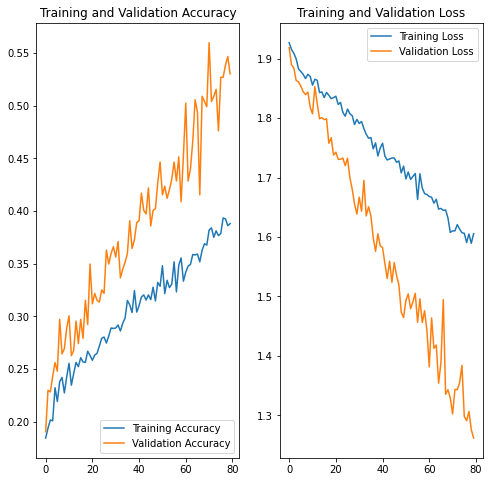

In [69]:
acc_1 = history1.history['accuracy']
val_acc_1 = history1.history['val_accuracy']

loss_1 = history1.history['loss']
val_loss_1 = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_1, label='Training Accuracy')
plt.plot(epochs_range, val_acc_1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_1, label='Training Loss')
plt.plot(epochs_range, val_loss_1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [73]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.10,
      height_shift_range=0.10,
      #shear_range=0.2,
      zoom_range=0.5,
      horizontal_flip=False,
      vertical_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=os.path.join(current_working_dir, train_path),
                                                     shuffle=True,
                                                     target_size=(image_shape,image_shape),
                                                     class_mode='sparse')

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=os.path.join(current_working_dir, validation_path),
                                                 target_size=(image_shape, image_shape),
                                                 class_mode='sparse')

model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(image_shape, image_shape, 3)),
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(7)
])
model2.summary()
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=80
history2 = model2.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_validation / float(batch_size)))
)

Found 2450 images belonging to 7 classes.
Found 609 images belonging to 7 classes.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 48, 48, 16)        448       
                                                                 
 conv2d_26 (Conv2D)          (None, 48, 48, 16)        2320      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 conv2d_28 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/80
25/25 [==============================] - 28s 1s/step - loss: 1.9466 - accuracy: 0.1359 - val_loss: 1.9457 - val_accuracy: 0.1429
Epoch 2/80
25/25 [==============================] - 26s 1s/step - loss: 1.9461 - accuracy: 0.1371 - val_loss: 1.9432 - val_accuracy: 0.1478
Epoch 3/80
25/25 [==============================] - 26s 1s/step - loss: 1.9421 - accuracy: 0.1592 - val_loss: 1.9361 - val_accuracy: 0.1954
Epoch 4/80
25/25 [==============================] - 26s 1s/step - loss: 1.9393 - accuracy: 0.1527 - val_loss: 1.9256 - val_accuracy: 0.1938
Epoch 5/80
25/25 [==============================] - 26s 1s/step - loss: 1.9308 - accuracy: 0.1600 - val_loss: 1.9346 - val_accuracy: 0.1642
Epoch 6/80
25/25 [==============================] - 26s 1s/step - loss: 1.9257 - accuracy: 0.1845 - val_loss: 1.9231 - val_accuracy: 0.1823
Epoch 7/80
25/25 [==============================] - 26s 1s/step - loss: 1.9281 - accuracy: 0.1673 - val_loss: 1.9290 - val_accuracy: 0.1970
Epoch 8/80
25/25 [==

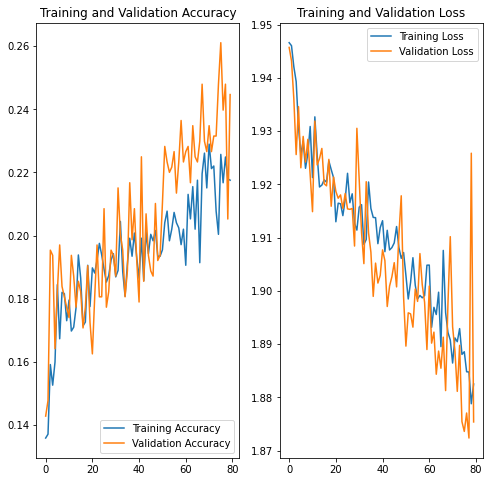

In [75]:
acc_2 = history2.history['accuracy']
val_acc_2 = history2.history['val_accuracy']

loss_2 = history2.history['loss']
val_loss_2 = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
batch_size = 80
image_gen_train = ImageDataGenerator(
      rescale=1./255)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=os.path.join(current_working_dir, train_path),
                                                     shuffle=True,
                                                     target_size=(image_shape,image_shape),
                                                     class_mode='sparse')

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=os.path.join(current_working_dir, validation_path),
                                                 target_size=(image_shape, image_shape),
                                                 class_mode='sparse')

model3 = Sequential()
model3.add(ResNet50(input_shape=(image_shape, image_shape, 3), weights='imagenet', include_top=False))
model3.add(GlobalMaxPooling2D())
model3.add(Dropout(0.3))
model3.add(Dense(7,activation=None))
model3.summary()
model3.compile('SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=80
history3 = model3.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_validation / float(batch_size)))
)

Found 2450 images belonging to 7 classes.
Found 609 images belonging to 7 classes.
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d_5 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_15 (Dropout)        (None, 2048)              0         
                                                                 
 dense_19 (Dense)            (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/80
13/31 [===========>..................] - ETA: 4:06 - loss: 4.3272 - accuracy: 0.1875

In [ ]:
acc_3 = history3.history['accuracy']
val_acc_3 = history3.history['val_accuracy']

loss_3 = history3.history['loss']
val_loss_3 = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_3, label='Training Accuracy')
plt.plot(epochs_range, val_acc_3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_3, label='Training Loss')
plt.plot(epochs_range, val_loss_3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()